# **Exploratory Data Analysis (EDA)** 

## Objectives

This notebook performs exploratory data analysis (EDA) on the processed dataset to better understand the engineered features created during the ETL stage. It combines statistical hypothesis testing and graphical exploration to identify meaningful patterns, validate assumptions, and confirm relationships relevant to fraud detection.

The insights from this analysis will provide a deeper understanding of feature significance, support model development, and inform the design of visual elements in the Power BI dashboard.

The tests for the following hypotheses compare two groups (fraudulent vs non-fraudulent transactions) using non-parametric data (data that is skewed, contains outliers, or is better described by ranks or medians rather than means). For this reason, I use the Mann–Whitney U test (which is ideally suited to this scenario):
- H1: Fraud increases with distance from home.
- H2: Fraud increases with distance from the last transaction.
- H3: Fraud increases with ratio to median purchase price.

In comparison, the Chi-square test of independence is used for the following hypotheses, as they involve categorical variables and assess whether there is a significant association between fraud occurrence and different transaction characteristics.

The Chi-square test is appropriate when comparing frequency counts across categories (e.g., online vs offline, chip used vs not used). It evaluates whether observed differences between groups are likely due to chance or reflect a genuine relationship.

Where Chi-square test results include contingency tables with very small expected cell counts (typically fewer than five), Fisher’s Exact Test is also carried out, as it provides a more reliable result for small samples.

Hypotheses tested with Chi-square (and Fisher's Exact if needed):
- H4: Online orders are more likely to be fraudulent.
- H5: Chip or PIN use reduces fraud likelihood.
- H6: Fraud likelihood varies by repeat retailer.
- H8: Fraud likelihood depends on the combination of online order and chip use (interaction effect).

**Note:**
- H7: Threshold tuning will be explored in the modelling notebook using Precision–Recall curve analysis to illustrate how different cost trade-offs affect performance. This step demonstrates the balance between detecting more fraud and reducing false positives, but it is not a statistical hypothesis test.

## Inputs
- Processed dataset data/processed/card_transdata_processed.csv produced from ETL (which was derived from 100k stratified sample)

## Outputs
- Statistical test results (Mann–Whitney U and Chi-square).
- Visualisations showing feature distributions and comparisons between fraud and non-fraud transactions.
- Business insights highlighting key fraud detection patterns.
- Results from this notebook will also inform:
    - Modelling (feature selection and variable importance).
    - Power BI Dashboard Reports

---

# Change working directory

I need to change the working directory from the current folder to its parent folder (required because the notebook is being run from inside the jupyter notebooks subfolder). In the code below, I change the working directory from its current folder to its parent folder.  
* I access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'c:\\Current_DA\\Credit_Card-Fraud_Analysis_Updated\\jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chdir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'c:\\Current_DA\\Credit_Card-Fraud_Analysis_Updated'

# Section 1: Libraries for Visualisations, Data Check and Class Distribution Check

In this first section, the required data analysis and visualisation libraries are loaded to support statistical testing and exploratory analysis.

**Note on Effect Size Calculations:** The cliffs_delta library is included here for later use in statistical testing, providing efficient Cliff’s Delta calculations. Given the dataset size (100k rows, resulting in around 800 million potential pairwise comparisons per test), this optimised implementation helps avoid the computational overhead of manual sampling while maintaining accuracy.

Quick checks are performed to ensure the processed dataset produced in the ETL stage has loaded correctly and matches the expected structure (I expect to see extra engineered columns whilst the fraud class distribution should remain the same):
- Load the processed dataset from data/processed/card_transdata_processed.csv
- Conduct basic shape and structure checks
- Verify data loaded correctly before proceeding to hypothesis testing
- Verify fraud rate matches the rate expected from sample metadata file (8.74%)
- Check imbalance ratio 

**Results:**
- Dataframe loads and shape as expected: 100,000 rows × 17 columns
- First 5 rows load and display as expected
- Fraud rate is 8.74% and this matches the rate in the sample metadata file
- Imbalance ratio is 1:10.4 (non-fraud to fraud)

Results confirm the processed file matches expected structure and is ready for exploratory analysis.


In [4]:
# Import Data analysis and visualisation libraries for EDA
# Libraries for numerical operations and data manipulation

# Core file handling libraries
from pathlib import Path # load the pathlib library

import numpy as np # for numerical operations
import pandas as pd # for data manipulation

# Libraries for visualisation
import matplotlib.pyplot as plt # for basic plotting
import seaborn as sns # for enhanced visualisations
import plotly.express as px # for interactive visualisations

# Libraries for statistical analysis
from scipy import stats # Statistical libraries
from scipy.stats import chi2_contingency # Chi-squared test
from cliffs_delta import cliffs_delta # for efficient effect size calculation with large datasets


# Load processed dataset (output from 100k 01_ETL.ipynb) and check structure
df = pd.read_csv("data/processed/card_transdata_processed.csv")

df.shape # display the shape of the dataframe

(100000, 17)

In [5]:
df.head() # display the first 5 rows of the dataframe to check data loaded correctly

distance_from_home  distance_from_last_transaction  \
0           19.179396                        0.178758   
1           47.192898                        1.224832   
2           54.389043                        5.290910   
3            3.129745                        0.607212   
4            0.925275                        2.238057   

   ratio_to_median_purchase_price  repeat_retailer  used_chip  \
0                        2.979353                1          0   
1                        0.293538                1          1   
2                        4.492304                1          1   
3                        0.357527                1          0   
4                        0.684942                0          0   

   used_pin_number  online_order  fraud  log_distance_from_home  \
0                0             1      0                3.004662   
1                0             1      0                3.875212   
2                0             0      0                4.014382   
3                0             1      0                1.418216   
4                0             0      0                0.655069   

   log_distance_from_last_transaction  log_ratio_to_median_purchase_price  \
0                            0.164461                            1.381119   
1                            0.799681                            0.257381   
2                            1.839106                            1.703348   
3                            0.474501                            0.305665   
4                            1.174974                            0.521731   

   log_distance_from_home_bin  log_purchase_price_bin  \
0                           3                       4   
1                           4                       0   
2                           4                       4   
3                           1                       0   
4                           0                       1   

   log_distance_from_last_transaction_bin  online_high_distance  \
0                                       0                     1   
1                                       2                     1   
2                                       4                     0   
3                                       1                     0   
4                                       3                     0   

  online_chip_category  online_and_chip  
0       online_no_chip                0  
1     online_with_chip                1  
2    offline_with_chip                0  
3       online_no_chip                0  
4      offline_no_chip                0

# Section 1.1
**Class Distribution Additional Checks and Visualisation**

The proportion of fraudulent and non-fraudulent transactions is visualised further here to confirm the class balance. The dataset shows 8.7 % fraud and 91.3 % non-fraud, reflecting the expected imbalance from the full dataset.

Two visuals are provided side by side for clarity:
- A bar chart showing transaction counts by class.
- A pie chart illustrating percentage distribution.

Matplotlib was used to create both a bar chart and a pie chart showing the distribution of fraudulent and non-fraudulent transactions.
Matplotlib provides fine control over layout and styling, making it ideal for simple visual checks like class balance. 

This confirms that the sampling and processing steps preserved the original class proportions, and that fraud remains a minority class for all subsequent analysis and modelling.

In [6]:

# Display fraud rate and counts clearly
fraud_count = int(df['fraud'].sum()) # count the number of fraud cases
fraud_rate = df['fraud'].mean() # calculate the fraud rate
total_rows = df.shape[0] # get the total number of transactions
print(f"Fraud rate: {fraud_rate:.2%} ({fraud_count} fraud cases out of {total_rows} total transactions)") # display fraud rate and counts clearly

# Verify against expected rate from sample_log.json
expected_fraud_rate = 0.0874  # 8.74% from stratified sampling
rate_difference = abs(fraud_rate - expected_fraud_rate) # calculate difference

if rate_difference < 0.0001:  # allows for tiny floating point difference
    print(f"Class balance matches expected rate ({expected_fraud_rate:.2%})") # print confirmation if rates match
else:
    print(f"Mismatch Fraud rate {fraud_rate:.4%} differs from expected {expected_fraud_rate:.2%}") # print mismatch if rates differ

# Calculate imbalance ratio
imbalance_ratio = (1 - fraud_rate) / fraud_rate # ratio of non-fraud to fraud cases
print(f"Imbalance ratio is: 1:{imbalance_ratio:.1f} (non-fraud to fraud)") # display imbalance ratio

Fraud rate: 8.74% (8740 fraud cases out of 100000 total transactions)
Class balance matches expected rate (8.74%)
Imbalance ratio is: 1:10.4 (non-fraud to fraud)


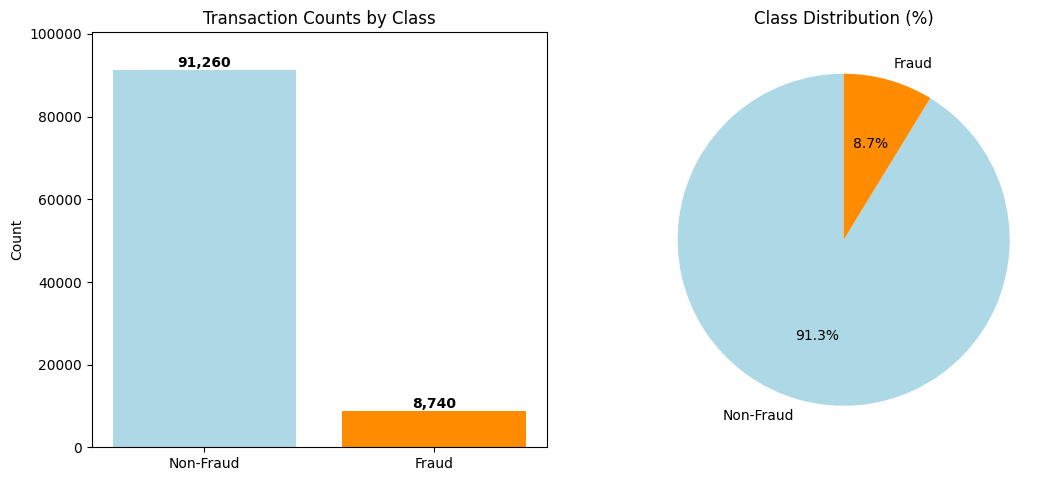

Class imbalance: 8.74% fraud, 91.26% non-fraud
Imbalance ratio: 1:10


In [7]:
# Visualise overall fraud class balance (Matplotlib)
fraud_counts = df['fraud'].value_counts() # Count of each class
fraud_pct = df['fraud'].value_counts(normalize=True) # Percentage of each class

fig, axes = plt.subplots(1, 2, figsize=(12, 6)) # 1 row, 2 colmumns for side-by-side plots

# Fraud Count Bar Plot
axes[0].bar(['Non-Fraud', 'Fraud'], fraud_counts.values, color=['lightblue', 'darkorange']) # bar chart
axes[0].set_ylabel('Count') # y-axis label
axes[0].set_title('Transaction Counts by Class') # title
axes[0].set_ylim(0, fraud_counts.max() * 1.1) # set y-axis limit
for i, v in enumerate(fraud_counts.values): # loop through bars
    axes[0].text(i, v, f'{v:,}', ha='center', va='bottom', fontweight='bold') # value labels

# Percentage Pie Plot
axes[1].pie(fraud_pct.values, labels=['Non-Fraud', 'Fraud'], autopct='%1.1f%%',  # display percentages
            colors=['lightblue', 'darkorange'], startangle=90) # pie chart
axes[1].set_title('Class Distribution (%)') # title

plt.tight_layout(pad=5.0) # adjust layout
plt.show() # display plot

print(f"Class imbalance: {fraud_pct[1]:.2%} fraud, {fraud_pct[0]:.2%} non-fraud") # print class percentages
print(f"Imbalance ratio: 1:{int(fraud_pct[0]/fraud_pct[1])}") # print imbalance ratio

## **Section 2: Feature Checks**

In the ETL stage, several new features were engineered to enhance interpretability and improve model performance. This section explores those features to understand their distributions, relationships, and potential value for fraud detection.

**Feature Groups**

* Log-transformed features:  
  * log_distance_from_home, log_distance_from_last_transaction, log_ratio_to_median_purchase_price  
  * These transformations reduce extreme skew in continuous variables, making them more stable, interpretable, and comparable across fraud groups.

* Binned features:  
  * log_distance_from_home_bin, log_purchase_price_bin, log_distance_from_last_transaction_bin  
  *  These bin the log-transformed variables into discrete ranges, helping to identify threshold effects (e.g., greater fraud likelihood beyond certain distances or price levels).

* Interaction features:  
   online_high_distance, online_chip_category, online_and_chip  
   These capture combined behavioural patterns such as online transactions occurring far from home or those without chip use — both potential indicators of higher fraud risk.

**Visualisations**

Visualisations were used to examine how these engineered features behave and to confirm that they capture meaningful relationships with fraud.

* **Matplotlib** was used for histograms and boxplots, chosen for its flexibility when comparing continuous and categorical features side by side.
* **Seaborn** was used for bar charts to visualise fraud rates, providing clear statistical styling and consistent design.

These tools together enable comparison of feature distributions, group differences, and categorical risk patterns.

**What the Visualisations Show**

The visualisations collectively provide an intuitive overview of how engineered features behave and relate to fraud.

* **Histograms** show that after log transformation, the continuous features are more compact and normally shaped, with most transactions occurring at typical values and a few extending into higher-risk extremes.

* **Boxplots** reveal clear median differences between fraudulent and non-fraudulent transactions, particularly for purchase price ratio, confirming that higher distances and unusual purchase amounts are associated with fraud.

* **Bar charts** translate these relationships into clear categorical comparisons — for example, fraud rates rise sharply with distance-from-home and are highest for online transactions without chip verification.

Together, these visuals complement the statistical tests by revealing where the largest differences occur and validating that the engineered features capture real behavioural signals of fraud risk.

**Key Insights**

* Log-transformed features produce stable, interpretable distributions and highlight higher median values in fraud cases.
* Fraud likelihood increases at greater distances from home, particularly beyond upper bins of the log-transformed distance variable.
* Online transactions, especially those without chip authentication, show substantially higher fraud rates.
* These patterns confirm that the engineered variables are well-suited for modelling and add meaningful predictive information.


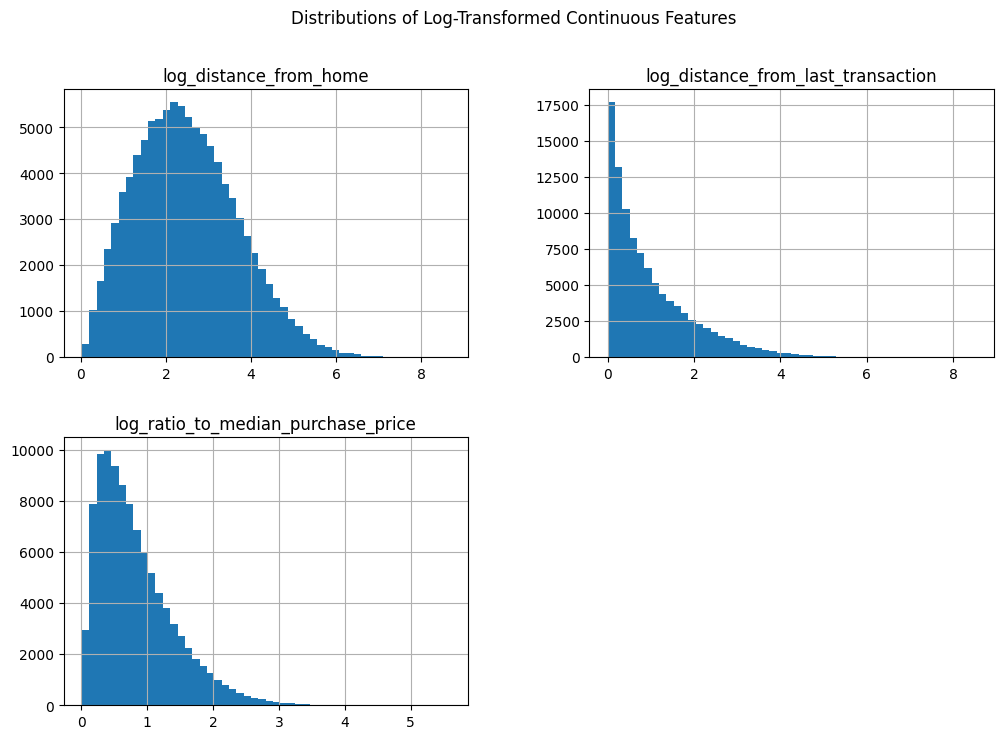

In [8]:
# Log Transform Features Visualisation
# Explore log-transformed continuous features using Matplotlib histograms
cont_cols = ["log_distance_from_home",
             "log_distance_from_last_transaction",
             "log_ratio_to_median_purchase_price"] # List of log-transformed columns

df[cont_cols].hist(bins=50, figsize=(12,8)) # plot histograms for each log-transformed feature
plt.suptitle("Distributions of Log-Transformed Continuous Features") # overall title
plt.show() # show the plots

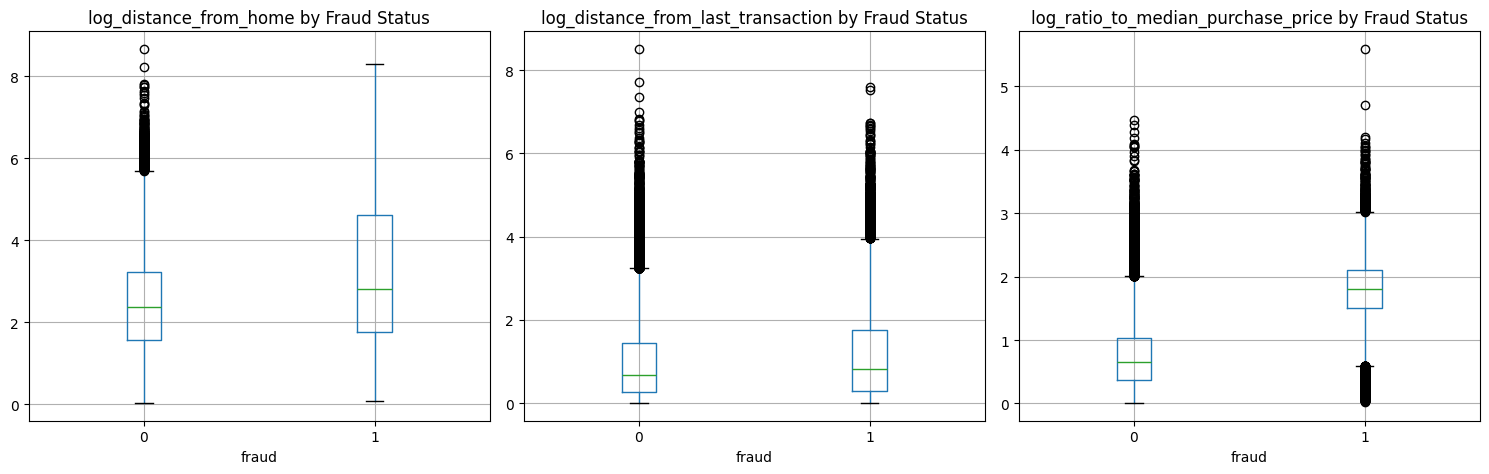

In [9]:
# Side-by-side boxplots for each log-transformed feature
fig, axes = plt.subplots(1, 3, figsize=(15, 5)) # 1 row, 3 columns
for idx, col in enumerate(cont_cols): # loop through each log-transformed column
    df.boxplot(column=col, by='fraud', ax=axes[idx]) # boxplot by fraud status
    axes[idx].set_title(f'{col} by Fraud Status') # set title for each subplot
plt.suptitle('') # remove automatic suptitle
plt.tight_layout() # adjust layout
plt.show() # display plot

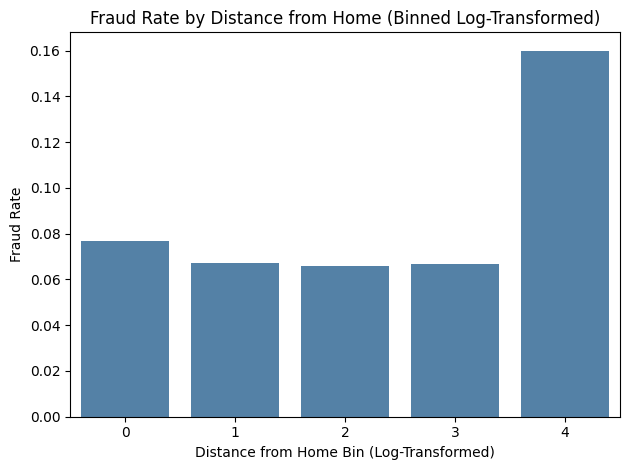

In [10]:
# Binned Feature 1 (log_distance_from_home_bin) Visualisation
# Explore binned feature using Seaborn and Matplotlib bar plot

fraud_by_bin = (
    df.groupby("log_distance_from_home_bin")["fraud"]
      .mean()
      .rename("fraud_rate")
      .reset_index()
) # Calculate fraud rate by log_distance_from_home_bin

sns.barplot(x="log_distance_from_home_bin", y="fraud_rate", data=fraud_by_bin, color="steelblue")
plt.ylabel("Fraud Rate") # y-axis label
plt.xlabel("Distance from Home Bin (Log-Transformed)") # x-axis label
plt.title("Fraud Rate by Distance from Home (Binned Log-Transformed)") # title
plt.tight_layout() # Adjust layout
plt.show() # Show plot


online_chip_category  fraud_rate
0      offline_no_chip    0.017284
1    offline_with_chip    0.005520
2       online_no_chip    0.144818
3     online_with_chip    0.094146

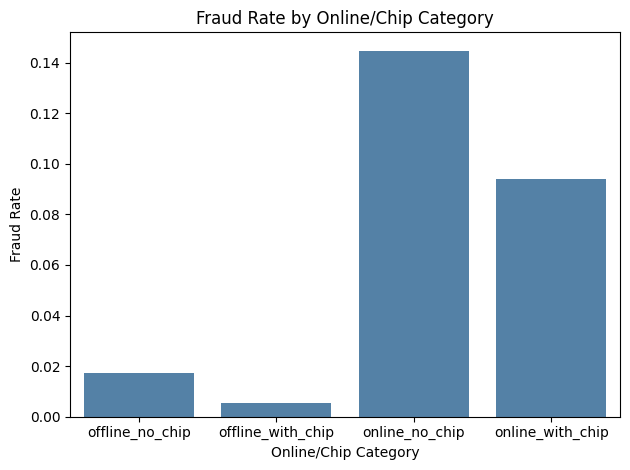

In [11]:
# Explore fraud rates by online/chip category (Seaborn and Matplotlib bar chart)
fraud_by_category = (
    df.groupby("online_chip_category")["fraud"]
      .mean()
      .rename("fraud_rate")
      .reset_index()
)
display(fraud_by_category) # Display the calculated fraud rates

# Bar chart of fraud rates by online/chip category
sns.barplot(x="online_chip_category", y="fraud_rate", data=fraud_by_category, color="steelblue")
plt.ylabel("Fraud Rate") # y-axis label
plt.xlabel("Online/Chip Category") # x-axis label
plt.title("Fraud Rate by Online/Chip Category") # title
plt.tight_layout() # Adjust layout
plt.show() # Show plot

---
# Section 3: Statistical Tests (using Helper Functions)

The helper functions below are designed to automate Mann–Whitney U tests and Chi-square tests with effect size calculations. These functions are reused throughout the hypothesis testing section later in the notebook.

I use helper functions to keep the analysis consistent and reproducible by wrapping common tests in small, reusable functions. This approach helps avoid copy-and-paste errors, ensures the same parameters are applied each time, and produces comparable outputs (test statistic, p-value, effect size, and a quick visual where relevant). It also prevents unnecessary repetition, following the DRY (Don’t Repeat Yourself) principle. I write the helpers once and use them multiple times across the different hypothesis tests.

What the helper functions do:
- run_mw_test(df, col): Mann–Whitney U test for a continuous feature vs. fraud (0/1) + Cliff’s δ effect size. Designed for non-normal data and unequal variances.
-run_chi2(df, col): Chi-square test for a categorical feature vs. fraud + Cramér’s V effect size and a contingency table.

In [12]:
# ============================================================================
# HELPER FUNCTION 1: MANN-WHITNEY U TEST WITH CLIFF'S DELTA
# ============================================================================
# For continuous features: Tests whether medians differ between fraud groups
# Returns test statistic, p-value, and Cliff's Delta effect size
# ============================================================================

def run_mw_test(df, col):
    """
    Perform Mann-Whitney U test comparing a continuous variable between fraud and non-fraud groups.
    Also calculates Cliff's Delta for effect size.
    
    Parameters:
    - df: DataFrame containing the data
    - col: Column name to test
    """
    
    # ─────────────────────────────────────────────────────────────────────
    # Split data by fraud status
    # ─────────────────────────────────────────────────────────────────────
    fraud = df[df["fraud"] == 1][col].dropna()       # Fraud cases only
    non_fraud = df[df["fraud"] == 0][col].dropna()   # Non-fraud cases only

    # ─────────────────────────────────────────────────────────────────────
    # Perform Mann-Whitney U test (non-parametric)
    # ─────────────────────────────────────────────────────────────────────

    u_stat, p_value = stats.mannwhitneyu(fraud, non_fraud, alternative='two-sided') # two-sided test
    
    # ─────────────────────────────────────────────────────────────────────
    # Calculate Cliff's Delta effect size
    # ─────────────────────────────────────────────────────────────────────
    # Cliff's Delta: Non-parametric effect size for ordinal/continuous data
    # Range: -1 (non-fraud always higher) to +1 (fraud always higher)
    # Interpretation: |δ| = 0.5 means groups overlap by only 50%
    
    cliffs_delta_result = cliffs_delta(fraud.values, non_fraud.values) # calculate Cliff's Delta
    
    # Handle different return types (library version compatibility)
    # Some versions return tuple (value, interpretation), others return value only
    # depending on the library version. This check ensures compatibility and prevents errors ()

    if isinstance(cliffs_delta_result, tuple):
        cliffs_delta_value = cliffs_delta_result[0] # extract numeric value
    else:
        cliffs_delta_value = cliffs_delta_result # else its already numeric
    
    # ─────────────────────────────────────────────────────────────────────
    # Interpret effect size using standard thresholds
    # ─────────────────────────────────────────────────────────────────────
    # Thresholds based on Romano et al. (2006) guidelines

    if abs(cliffs_delta_value) < 0.147:
        effect = "negligible" # negligible effect
    elif abs(cliffs_delta_value) < 0.33:
        effect = "small" # small effect
    elif abs(cliffs_delta_value) < 0.474:
        effect = "medium" # medium effect
    else:
        effect = "large" # large effect

    # ─────────────────────────────────────────────────────────────────────
    # Display results
    # ─────────────────────────────────────────────────────────────────────
    print(f"\nMann-Whitney U Test: {col}")
    print(f"U-statistic: {u_stat:.2f}")
    print(f"p-value: {p_value:.4e}")
    print(f"Cliff's Delta: {cliffs_delta_value:.3f} ({effect} effect)")
    print(f"Fraud median: {fraud.median():.3f}")
    print(f"Non-fraud median: {non_fraud.median():.3f}")
    
    # Return results in dictionary for programmatic use (storing results, building comparisons)
    return {"u_stat": u_stat, "p_value": p_value, "cliffs_delta": cliffs_delta_value, "effect": effect}


# ============================================================================
# HELPER FUNCTION 2: CHI-SQUARE TEST WITH CRAMÉR'S V
# ============================================================================
# For categorical features: Tests association with fraud
# Returns chi-square statistic, p-value, and Cramér's V effect size
# ============================================================================

def run_chi2(df, col):
    """
    Perform Chi-square test of independence between a categorical variable and fraud.
    Also calculates Cramér's V for effect size.
    
    Parameters:
    - df: DataFrame containing the data
    - col: Column name to test
    """
    # ─────────────────────────────────────────────────────────────────────
    # Create contingency table (crosstab)
    # ─────────────────────────────────────────────────────────────────────
    # Rows: Categories of the feature being tested
    # Columns: Fraud status (0 = non-fraud, 1 = fraud)

    ct = pd.crosstab(df[col], df["fraud"]) # contingency table
    
    # ─────────────────────────────────────────────────────────────────────
    # Perform Chi-square test of independence
    # ─────────────────────────────────────────────────────────────────────
    # Null hypothesis: Feature and fraud are independent (no association)
    # Returns: chi2 statistic, p-value, degrees of freedom, expected frequencies

    chi2, p_value, dof, expected = chi2_contingency(ct) # chi-square test

    # ─────────────────────────────────────────────────────────────────────
    # Calculate Cramér's V effect size
    # ─────────────────────────────────────────────────────────────────────
    # Cramér's V: Normalised chi-square, ranges from 0 (no association) to 1
    # Formula: V = sqrt(chi2 / (n × min_dimension))
    # Where min_dimension = min(rows-1, cols-1)
   
    n = ct.sum().sum() # total sample size
    min_dim = min(ct.shape[0] - 1, ct.shape[1] - 1) # minimum dimension

    # avoid division by zero (shouldn't happen with valid contingency table)
    cramers_v = np.sqrt(chi2 / (n * min_dim)) if min_dim > 0 else 0  
    
    # ─────────────────────────────────────────────────────────────────────
    # Interpret effect size
    # ─────────────────────────────────────────────────────────────────────
    # Thresholds for 2×2 tables (Cohen's guidelines)
    # For larger tables, thresholds are slightly different but we use same

    if cramers_v < 0.1:
        effect = "negligible"  # Weak or no association
    elif cramers_v < 0.3:
        effect = "small" # Modest association
    elif cramers_v < 0.5:
        effect = "medium" # Substantial association
    else:
        effect = "large" # Very strong association
    # ───────────────────────────────────────────────────────────────────
    # Display results
    # ─────────────────────────────────────────────────────────────────────
    print(f"\nChi-Square Test: {col}")  # title 
    print(f"Chi-square statistic: {chi2:.2f}") # chi-square statistic
    print(f"p-value: {p_value:.4e}") # p-value
    print(f"Degrees of freedom: {dof}") # degrees of freedom
    print(f"Cramér's V: {cramers_v:.3f} ({effect} effect)") # Cramér's V and effect size
    print(f"\nContingency Table:") # title contingency table
    print(ct) # print contingency table
    print(f"\nFraud rates by {col}:") # title fraud rates by category 

    # Calculate fraud rate, total count, and fraud count for each category
    fraud_rates = df.groupby(col)["fraud"].agg(['mean', 'count']) # calculate fraud rates
    fraud_rates.columns = ['fraud_rate', 'count'] # rename columns
    fraud_rates['fraud_rate_pct'] = fraud_rates['fraud_rate'] * 100
    print(fraud_rates) # print fraud rates table

    # Return results in dictionary for programmatic use (storing results, building comparisons)
    return {"chi2": chi2, "p_value": p_value, "cramers_v": cramers_v, "effect": effect, "contingency_table": ct} 

# Statistical Testing

The goal of the tests to determine whether there are statistically significant differences between fraudulent and non-fraudulent transactions across key variables. Two main types of tests are used:

Mann–Whitney U Test (Continuous variables)
- Used to compare distributions for continuous features such as distance_from_home, distance_from_last_transaction, and ratio_to_median_purchase_price.

These variables are non-normally distributed (confirmed using Shapiro–Wilk tests), so the Mann–Whitney U test is chosen as a non-parametric alternative to a t-test. Effect size is measured using Cliff’s Delta (δ) to understand the strength of the difference:
- |δ| < 0.147 = negligible
- |δ| < 0.33 = small
- |δ| < 0.474 = medium
- |δ| ≥ 0.474 = large

Chi-Square Test (Categorical variables)
Used to test the association between categorical variables (e.g., online order, chip use, repeat retailer) and fraud.
Effect size is measured using Cramér’s V, which quantifies how strongly the categorical variable is associated with fraud.
- <0.1 = negligible, 0.1–0.3 = small, 0.3–0.5 = medium, >0.5 = large


# Hypotheses Test and Visualisations

In this section, statistical tests are performed to examine the main hypotheses about fraud behaviour. Test are supported by relevant visualisations (where possible) to illustrate patterns and provide context for the statistical results.

**H1: Fraud increases with distance from home**  
- Aim: To test whether Fraud increases with distance from home.
- Test details:
    - Variable tested: log_distance_from_home
    - Test used: Mann–Whitney U (non-parametric)
    - Reason for log transformation: the original distance_from_home feature is highly right-skewed, so the log version provides a more stable comparison between groups.
- Results:
    - U-statistic: 478,018,965
    - p-value: 2.66 × 10⁻²⁰⁷
    - Cliff’s Delta (δ): 0.199 (small effect)
    - Median (fraud): 2.812
    - Median (non-fraud): 2.365
- Interpretation:
    - The difference between fraudulent and non-fraudulent transactions is statistically significant (p < 0.001), meaning that distance from home differs between the two groups.
    - Fraudulent transactions tend to occur at greater distances from home, as shown by the higher median for fraud cases.
    - Although statistically strong, the effect size is small (δ = 0.199), indicating that while distance from home is related to fraud likelihood, it is not a dominant predictor on its own.
- Distance from Home Visualisation (Matplotlib Bar Chart)
    - Matplotlib was chosen for its simplicity and clarity in showing trends across continuous variables.
    - The chart summarises the relationship between distance_from_home and fraud rate.
    - The dataset is binned into readable distance ranges, and the average fraud rate is plotted for each band.
    - Insights:
       - Fraud rates remain low at shorter distances but increase sharply for transactions beyond 100 km from home.
       - This visual supports the statistical finding (Mann–Whitney U test) that fraudulent transactions are significantly more likely to occur at greater distances from home.


Mann-Whitney U Test: log_distance_from_home
U-statistic: 478018965.00
p-value: 2.6633e-207
Cliff's Delta: 0.199 (small effect)
Fraud median: 2.812
Non-fraud median: 2.365


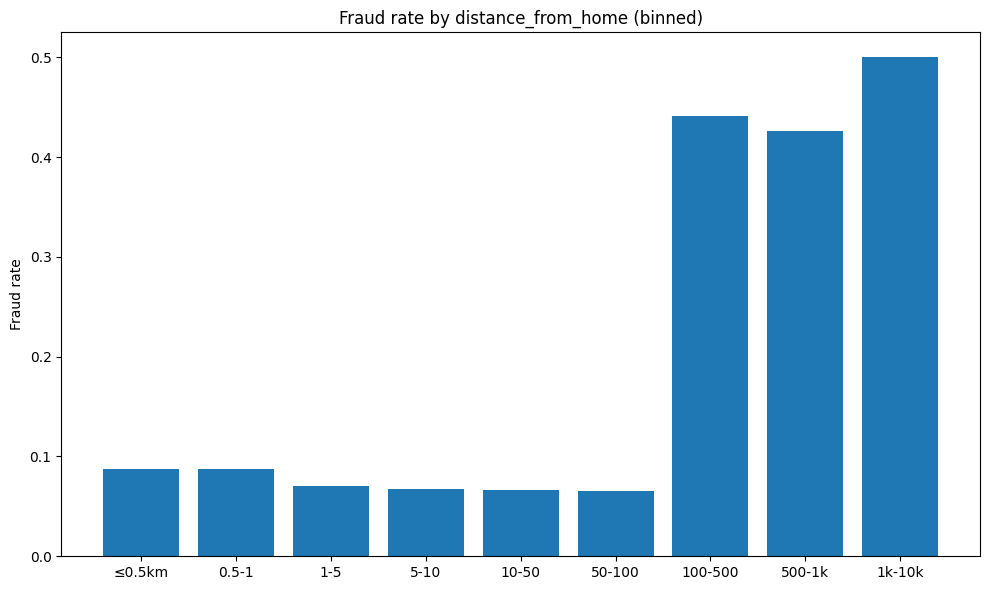

In [13]:
# =============================================================================
# H1: Fraud increases with distance from home
# Test: Mann–Whitney U on log_distance_from_home and fraud-rate by binned distance
# Rationale:
#   - Continuous feature is right-skewed (use non-parametric MWU)
#   - Binned distance shows threshold effects in fraud rates
# =============================================================================

# ─────────────────────────────────────────────────────────────────────────────
# Statistical test (continuous): log_distance_from_home vs fraud
# MWU compares distributions; Cliff's δ quantifies effect size
# ─────────────────────────────────────────────────────────────────────────────
run_mw_test(df,"log_distance_from_home") # Log distance from home (Mann–Whitney) with helper function

# separator line
print("=" * 90) # separator line

# ─────────────────────────────────────────────────────────────────────────────
# Fraud rate by raw distance_from_home (binned) for use in next bar plot
# Readable bins: categorical buckets to reveal thresholds and allow flexibility
# Bin edge widths can be tweaked later for clearer visual separation in plot
# ─────────────────────────────────────────────────────────────────────────────
dist_bins  = [-1, 0.5, 1, 5, 10, 50, 100, 500, 1_000, 10_000, max(10_001, df["distance_from_home"].max() + 1)]
dist_lbls  = ["≤0.5km","0.5-1","1-5","5-10","10-50","50-100","100-500","500-1k","1k-10k",">10k"]

df["dist_home_bin"] = pd.cut(df["distance_from_home"], bins=dist_bins, labels=dist_lbls) # create binned column

# aggregated fraud rates per distance bin (used for bar plot)
fraud_by_dist = (
    df.groupby("dist_home_bin", observed=True)["fraud"] # group by binned distance_from_home
      .mean() # calculate mean fraud rate
      .rename("fraud_rate") # rename column
      .reset_index() # reset index for clean DataFrame
)

# ─────────────────────────────────────────────────────────────────────────────
# Visual: Fraud rate by distance_from_home (binned) — Matplotlib
# ─────────────────────────────────────────────────────────────────────────────

plt.figure(figsize=(10,6))
plt.bar(fraud_by_dist["dist_home_bin"].astype(str), fraud_by_dist["fraud_rate"]) # bar chart
plt.ylabel("Fraud rate") # y-axis label
plt.title("Fraud rate by distance_from_home (binned)") # title
plt.tight_layout() # Adjust layout
plt.show() # display plot

**H2: Fraud increases with distance from the last transaction (Mann–Whitney U test)**
- Aim: To test whether fraud increases with distance from the last transaction.
- Test details:
    - Variable tested: log_distance_from_last_transaction
    - Test used: Mann–Whitney U (non-parametric)
    - Reason for log transformation: the variable is highly skewed, and log transformation reduces the effect of extreme values while maintaining relative differences.
- Results:
    - U-statistic: 434,521,269
    - p-value: 1.22 × 10⁻⁴³
    - Cliff’s Delta (δ): 0.090 (negligible effect)
    - Median (fraud): 0.809
    - Median (non-fraud): 0.682
- Interpretation:
   - There is a statistically significant difference between fraudulent and non-fraudulent transactions (p < 0.001), indicating that fraudulent transactions tend to occur slightly farther from the previous transaction.
    - However, the effect size is negligible (δ = 0.090), meaning that while the difference exists statistically due to the large sample size, the practical impact is minimal.
    - This suggests that distance from the previous transaction alone does not strongly distinguish fraud from genuine behaviour.
- Visualisation - Distance from Last Transaction Chart (Interactive violin plot)
    - A Plotly interactive violin plot was used to visualise how distance_from_last_transaction differs between fraudulent and non-fraudulent transactions. Plotly was chosen here because it allows interactive exploration of outliers and distribution shapes (users can hover to inspect values or toggle classes to isolate group behaviour).This was selected as the violin shape displays both density and spread, while the overlaid box shows median and quartiles, linking directly to the Mann–Whitney U test results. Interactivity makes it easier to inspect rare, extreme transactions that might indicate unusual activity patterns.
    - The visual supports the statistical finding that fraudulent transactions have a slightly wider spread of distances but are not dramatically different overall.

In [14]:
# =============================================================================
# H2: Fraud increases with distance from the last transaction
# Test: Mann–Whitney U on log_distance_from_last_transaction
# Visual: Plotly violin plot (shows distribution and box and outliers)
# Rationale:
#   - Continuous feature, skewed → non-parametric MWU test
#   - Visual clarifies group differences and spread
# =============================================================================

# ─────────────────────────────────────────────────────────────────────────────
# Statistical test: compare fraud vs non-fraud distributions
# ─────────────────────────────────────────────────────────────────────────────
run_mw_test(df, "log_distance_from_last_transaction")

print("=" * 90) # separator line

# ─────────────────────────────────────────────────────────────────────────────
# Visual: Violin plot – log_distance_from_last_transaction by fraud status
# Shows median (white dot), IQR (box), and full distribution shape
# Helpful for visualising skew and overlap between fraud groups
# ─────────────────────────────────────────────────────────────────────────────
# Map numeric fraud flag (label for readability)

df['fraud_label'] = df['fraud'].map({0: 'Non-Fraud', 1: 'Fraud'}) # map fraud to labels for clarity

fig = px.violin(df, x='fraud_label', y='log_distance_from_last_transaction', # Violin plot
                box=True,  # embed boxplot summary inside violin
                points='outliers',  # show individual outlier points
                color='fraud_label', # color by fraud status
                labels={'fraud_label': 'Transaction Type',  # axis labels
                        'log_distance_from_last_transaction': 'Log Distance from Last Transaction'}, # axis labels
                title='Distance from Last Transaction: Fraud vs Non-Fraud', # title
                  color_discrete_map={'Non-Fraud': '#2ecc71', 'Fraud': '#e74c3c'}) # green for non-fraud, red for fraud


fig.show() # display plot


Mann-Whitney U Test: log_distance_from_last_transaction
U-statistic: 434521269.00
p-value: 1.2200e-43
Cliff's Delta: 0.090 (negligible effect)
Fraud median: 0.809
Non-fraud median: 0.682


**H3: Fraud increases with ratio to median purchase price.**
- Aim: To test whether fraudulent transactions are associated with unusually high purchase values relative to the customer’s median purchase price.
- Test:
    - Compared ratio_to_median_purchase_price between fraud and non-fraud groups using the Mann–Whitney U test (a non-parametric alternative suitable for skewed data).
    - The log-transformed version was used to reduce extreme skew and allow fairer comparison of group medians.
- Results:
    - U-statistic: 677,872,887
    - p-value: < 0.001 (reported as 0.0000e+00)
    - Cliff’s Delta (δ): 0.700 (large effect)
    - Median (fraud): 1.803
    - Median (non-fraud): 0.651
 - Summary:
    - The difference between fraudulent and non-fraudulent transactions is highly significant (p < 0.001), with a large effect size (δ = 0.700).
    - Fraudulent transactions typically occur at much higher purchase ratios, meaning customers spend significantly more than usual when fraud occurs.
    - This makes the ratio to median purchase price one of the strongest predictors of fraud in this dataset.
- Visualisation 
    - Boxplots created with Seaborn and Matplotlib
    - These illustrate clear separation in medians and spread between the two groups.
    - Outliers were suppressed for readability, revealing a pronounced upward shift in fraud cases.
    - Seaborn was used for its statistical visual clarity, while Matplotlib ensured consistent layout and custom labelling across plots.


Mann-Whitney U Test: log_ratio_to_median_purchase_price
U-statistic: 677872887.00
p-value: 0.0000e+00
Cliff's Delta: 0.700 (large effect)
Fraud median: 1.803
Non-fraud median: 0.651


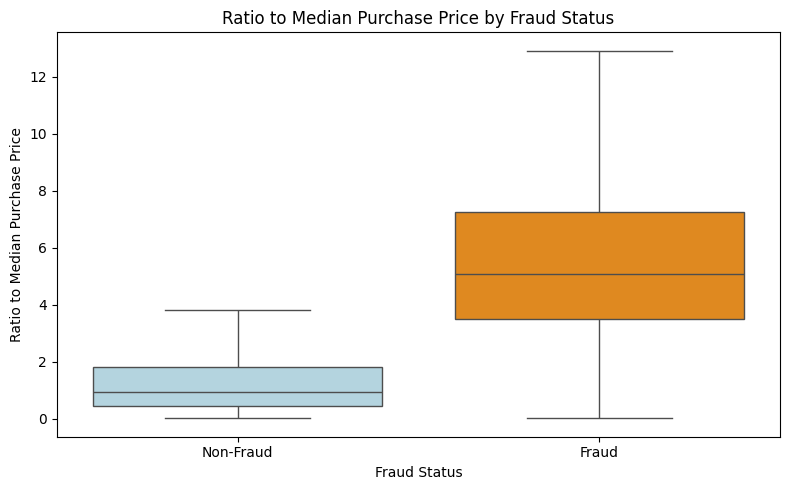

In [15]:
# =============================================================================
# H3: Fraud increases with ratio to median purchase price
# Test: Mann-Whitney U test (log_ratio_to_median_purchase_price vs fraud)
# Rationale:
# Continuous variable (purchase ratio) - Mann-Whitney U with Cliff's Delta
# Tests whether fraudulent transactions involve unusually high purchase amounts
# relative to customer's typical spending (median purchase price)
# Log transformation reduces extreme skew for fairer median comparison
# =============================================================================

# ─────────────────────────────────────────────────────────────────────────────
# Statistical test: log_ratio_to_median_purchase_price vs fraud (Mann-Whitney U)
# ─────────────────────────────────────────────────────────────────────────────
run_mw_test(df, "log_ratio_to_median_purchase_price")

print("=" * 90) # separator line

# ─────────────────────────────────────────────────────────────────────────────
# Visualisation: Purchase Price Ratio by Fraud Status (Seaborn boxplot)
# ─────────────────────────────────────────────────────────────────────────────
# Boxplot comparing ratio_to_median_purchase_price between fraud and non-fraud
# Shows clear separation in medians and spread between groups
# Outliers suppressed to reveal core distribution shift (fraud cases higher)

# Create boxplot with Seaborn (outliers removed for readability)
plt.figure(figsize=(8, 5))  # set figure size
sns.boxplot(
    x="fraud", 
    hue='fraud',
    legend=False,
    y="ratio_to_median_purchase_price",  # Original ratio (not log) for interpretability
    data=df, 
    showfliers=False,  # Remove outliers to show core distribution clearly
    palette=['lightblue', 'darkorange']  # Color by fraud status
)
plt.title("Ratio to Median Purchase Price by Fraud Status")  # title
plt.xlabel("Fraud Status")  # x-axis label
plt.ylabel("Ratio to Median Purchase Price")  # y-axis label (how much more than usual)
plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])  # readable x-axis labels
plt.tight_layout()  # adjust layout to prevent label cutoff
plt.show()  # display plot


**H4: Online orders are more likely to be fraudulent**  
- Aim: To test whether online transactions are disproportionately associated with fraud.
- Test details:
    - Variable tested: online_order
    - Test used: Chi-square test of independence
    - Rationale: both fraud and online_order are categorical (0/1) variables, so the Chi-square test assesses whether fraud frequency differs significantly between online and non-online transactions.
- Results:
    - Chi-square statistic: 3,696.00
    - p-value: < 0.001 (highly significant)
    - Degrees of freedom: 1
    - Cramér’s V: 0.192 (small effect)
    - Fraud rate:
        - Online orders: 12.7%
        - Non-online orders: 1.3%
- Interpretation:
    - Fraudulent transactions occur far more often in online orders (12.7%) than in offline transactions (1.3%).
    - Although the effect size is small (V = 0.192), the statistical significance is extremely high (p < 0.001), meaning the relationship is real and meaningful.
    - This supports the expectation that card-not-present transactions represent a higher fraud risk due to the lack of physical verification methods like chip and PIN.
- Visualisation
    - Bar plot using Seaborn to show the fraud rate for online and in-store transactions.
    - This chart makes the disparity between online and in-person transactions clear and intuitive for non-technical audiences.
    - Matplotlib was used to format consistent labelling and colour themes across all categorical plots.
    - This visual effectively complements the statistical findings by highlighting how much more frequently fraud occurs in online orders.


Chi-Square Test: online_order
Chi-square statistic: 3696.00
p-value: 0.0000e+00
Degrees of freedom: 1
Cramér's V: 0.192 (small effect)

Contingency Table:
fraud             0     1
online_order             
0             34415   460
1             56845  8280

Fraud rates by online_order:
              fraud_rate  count  fraud_rate_pct
online_order                                   
0                0.01319  34875        1.318996
1                0.12714  65125       12.714012


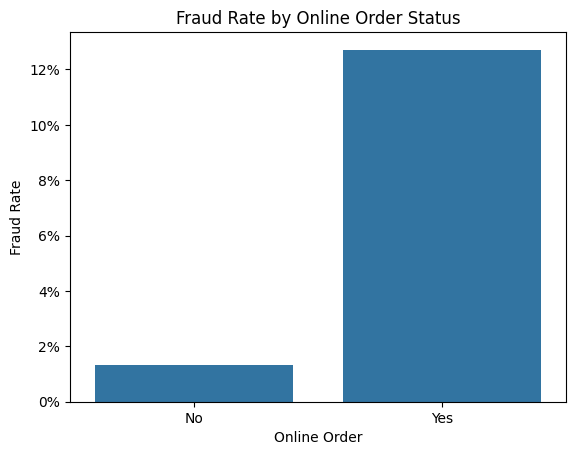

In [16]:
# =============================================================================
# H4: Online orders are more likely to be fraudulent
# Test: Chi-square test of independence on online_order vs fraud
# Visual: Seaborn bar plot showing fraud rate by online order status
# Rationale:
# Categorical variable Chi-square test with Cramér’s V effect size
# Visual confirms how fraud frequency differs between online and offline orders
# =============================================================================

# ─────────────────────────────────────────────────────────────────────────────
# Statistical test: online_order vs fraud (Chi-square)
# ─────────────────────────────────────────────────────────────────────────────

run_chi2(df, "online_order")

print("=" * 90) # separator line
# ─────────────────────────────────────────────────────────────────────────────
# Visual: Fraud rate by online order status (Seaborn bar plot)
# Displays proportion of fraudulent transactions for online vs offline
# Confirms online orders carry a higher fraud rate
# ─────────────────────────────────────────────────────────────────────────────

fraud_by_online = (
    df.groupby("online_order")["fraud"] # group by online_order
      .mean() # calculate mean fraud rate
      .rename("fraud_rate") # rename column for 
      .reset_index() # reset index for clean DataFrame
)

sns.barplot(x="online_order", y="fraud_rate", data=fraud_by_online, legend=False) # seaborn bar plot
plt.title("Fraud Rate by Online Order Status") # title
plt.xlabel("Online Order") #
plt.ylabel("Fraud Rate") # y-axis label
plt.xticks([0, 1], ['No', 'Yes']) # x-axis labels
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda v, _: f"{v:.0%}"))  # show percentages
plt.show()  # display plot


**H5: Chip or PIN use reduces fraud likelihood.**
- Aim: To test whether secure payment methods — specifically chip-based cards and PIN entry — are associated with lower fraud rates compared to transactions without these protections.
- Test:
    - Conducted Chi-square tests of independence for two binary variables: used_chip and used_pin_number, each against fraud.
    - These tests evaluate whether the likelihood of fraud differs significantly when chip or PIN authentication methods are used.
    - Both tests are suitable for categorical data and indicate whether the observed differences in fraud proportions are statistically meaningful.
- Results:
    - used_chip
        - χ² = 389.59, p < 0.001
        - Cramér’s V = 0.062 (negligible effect)
        - Fraud rate (no chip): 10.0%
        - Fraud rate (chip used): 6.3%
    - used_pin_number
        - χ² = 1011.01, p < 0.001
        - Cramér’s V = 0.101 (small effect)
        - Fraud rate (no PIN): 9.7%
        - Fraud rate (PIN used): 0.3%
- Summary:
    - Both tests show highly significant results (p < 0.001), indicating that chip and PIN usage is strongly associated with reduced fraud.
    - While effect sizes are small to negligible, the absolute difference in fraud rates is large (especially for PIN use, where the fraud rate is over 30 times lower).
    - These results align with real-world expectations: transactions requiring physical authentication or secure input methods are less vulnerable to fraud.
   - The findings complement those of H4 (online orders), suggesting that fraud risk increases in the absence of in-person verification mechanisms.
- Visualisation:
    - Plotly heatmap is used here to summarise the relationships between all categorical variables, including used_chip and used_pin_number. Plotly was chosen for its interactivity; it allows users to hover over each cell to view precise correlation values and quickly identify patterns across multiple variables. This makes it easier to explore relationships dynamically and to present the findings in a more engaging and accessible way compared to static plots.The visual also complements the Chi-square results by confirming the weak but statistically significant associations between secure payment methods and lower fraud rates.


Used chip vs fraud results:

Chi-Square Test: used_chip
Chi-square statistic: 389.59
p-value: 1.0152e-86
Degrees of freedom: 1
Cramér's V: 0.062 (negligible effect)

Contingency Table:
fraud          0     1
used_chip             
0          58609  6534
1          32651  2206

Fraud rates by used_chip:
           fraud_rate  count  fraud_rate_pct
used_chip                                   
0            0.100302  65143       10.030241
1            0.063287  34857        6.328714
Used pin number vs fraud results:

Chi-Square Test: used_pin_number
Chi-square statistic: 1011.01
p-value: 7.2655e-222
Degrees of freedom: 1
Cramér's V: 0.101 (small effect)

Contingency Table:
fraud                0     1
used_pin_number             
0                81159  8712
1                10101    28

Fraud rates by used_pin_number:
                 fraud_rate  count  fraud_rate_pct
used_pin_number                                   
0                  0.096939  89871        9.693895
1                  0

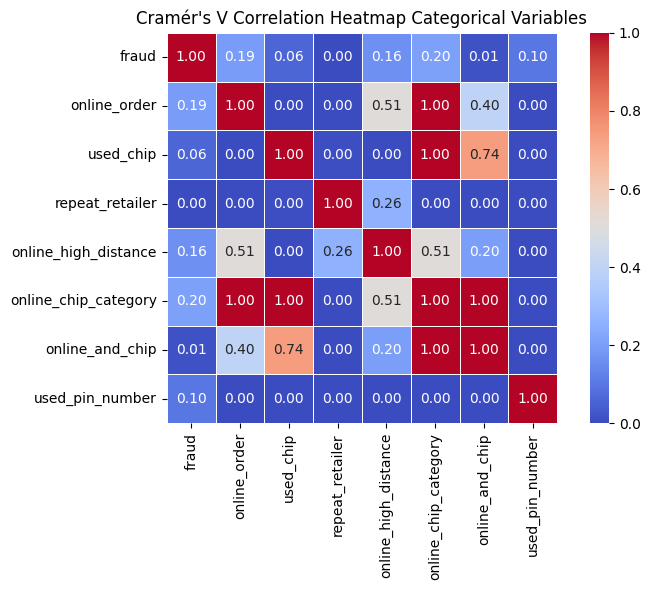

In [17]:
# =============================================================================
# H5: Chip use reduces fraud likelihood
# Test: Chi-square (used_chip vs fraud) and categorical association heatmap (Cramér's V)
# Rationale:
# Categorical variable - Chi-square with Cramér's V for effect size
# Heatmap summarises associations across all categorical features incl. fraud
# =============================================================================

# ─────────────────────────────────────────────────────────────────────────────
# Statistical test: used_chip vs fraud (Chi-square)
# ─────────────────────────────────────────────────────────────────────────────
print("Used chip vs fraud results:") # aids readability
h5a_chip = run_chi2(df, "used_chip") # used_chip vs fraud  
print("=" * 90)

# Used pin number vs fraud 
print("Used pin number vs fraud results:") # aids readability
h5b_pin = run_chi2(df, "used_pin_number") # Stores result for programmatic use
print("=" * 90)

# Display effect sizes clearly
print(f"Chip - Cramér's V: {h5a_chip['cramers_v']}")  # Prints chip result
print(f"PIN  - Cramér's V: {h5b_pin['cramers_v']}")   # Prints pin result
print("=" * 90)

# ─────────────────────────────────────────────────────────────────────────────
# Fraud association categorical heatmap (Cramér's V) with Plotly
# Covers more than H5 (it Summarises pairwise associations for all categorical variables and fraud)
# Values near 0 = weak/no association, near 1 = strong association
# ─────────────────────────────────────────────────────────────────────────────
cat_cols = [
    'fraud',
    'online_order',
    'used_chip',
    'repeat_retailer', # included though no impact expected
    'online_high_distance',
    'online_chip_category',
    'online_and_chip',
    'used_pin_number' # this is very unlikely to be used online
    
]
# Keep only columns that actually exist to avoid KeyErrors
cat_cols = [c for c in cat_cols if c in df.columns]

# ─────────────────────────────────────────────────────────────────────────────
# Categorical association heatmap (Cramér's V)
# Summarises pairwise associations among categorical vars and fraud
# Values near 0 = weak/no association, near 1 = strong association
# ─────────────────────────────────────────────────────────────────────────────

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix, correction=False)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    
    # Bias correction (Bergsma & Wicher / Wikipedia approach)
    phi2corr = max(0, phi2 - ((k-1)*(r-1)) / (n-1))
    rcorr = r - ((r-1)**2) / (n-1)
    kcorr = k - ((k-1)**2) / (n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Build the matrix
cramers_results = pd.DataFrame( # Initialize DataFrame for Cramér's V results
    np.zeros((len(cat_cols), len(cat_cols))), # zero matrix
    columns=cat_cols, index=cat_cols # set columns and index
)

for col1 in cat_cols: # compute Cramér's V for each pair of categorical variables
    for col2 in cat_cols:
        if col1 == col2:
            cramers_results.loc[col1, col2] = 1.0 # Cramér's V with itself is 1
        else:
            cramers_results.loc[col1, col2] = cramers_v(df[col1], df[col2]) # compute Cramér's V

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    cramers_results, # heatmap data
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5,
    square=True
)
plt.title("Cramér's V Correlation Heatmap Categorical Variables") # title
plt.tight_layout()
plt.show() # display plot


**H6: Repeat Retailer vs Fraud (Chi-Square Test, with Bar Plot)**
- Aim: To test whether transactions made with retailers that customers have previously visited are more or less likely to be fraudulent compared to first-time purchases.
- Test:
    - Conducted a Chi-square test of independence between repeat_retailer (0 = first-time retailer, 1 = repeat retailer) and fraud.
    - This test determines whether the proportion of fraudulent transactions differs between first-time and repeat retailers.
    - As both variables are binary, the Chi-square test is appropriate for assessing potential association.
- Results:
    - Chi-square statistic: 0.02
    - p-value: 0.876
    - Degrees of freedom: 1
    - Cramér’s V: 0.000 (negligible effect)
    - Fraud rates:
        - First-time retailer: 8.78%
        - Repeat retailer: 8.73%
- Summary:
    - There is no statistically significant association between repeat retailer status and fraud (p = 0.876).
    - Fraud occurs at nearly identical rates for both new and repeat retailers, indicating that customer familiarity with a retailer does not meaningfully influence the likelihood of fraudulent activity.
    - This suggests that repeat shopping patterns are not predictive of fraud in this dataset, possibly because fraudulent transactions are more influenced by contextual or behavioural factors (e.g. location, order type) rather than customer–retailer relationships.
    - The negligible Cramér’s V value (0.0005) confirms the absence of any meaningful effect.
- Visualisation:
    - A simple bar plot was created to compare fraud rates between first-time and repeat retailers.
    - This visual provides a clear illustration of the near-identical fraud rates between the two groups, reinforcing the statistical finding that retailer familiarity has no effect on fraud likelihood.
    - Seaborn was used for its concise syntax and automatic calculation of error bars, ensuring an easy-to-interpret comparison.

Repeat retailer vs fraud results:

Chi-Square Test: repeat_retailer
Chi-square statistic: 0.02
p-value: 8.7596e-01
Degrees of freedom: 1
Cramér's V: 0.000 (negligible effect)

Contingency Table:
fraud                0     1
repeat_retailer             
0                10875  1047
1                80385  7693

Fraud rates by repeat_retailer:
                 fraud_rate  count  fraud_rate_pct
repeat_retailer                                   
0                  0.087821  11922        8.782084
1                  0.087343  88078        8.734304


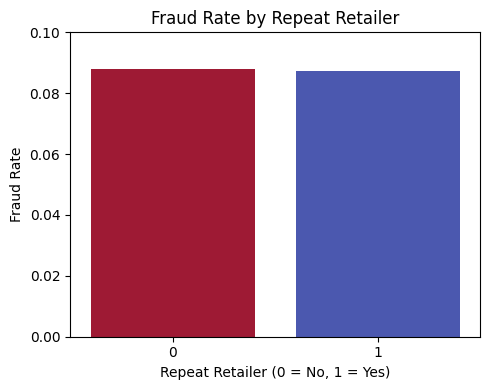

In [18]:
# =============================================================================
# H6: Fraud likelihood varies by repeat retailer
# Test: Chi-square (repeat_retailer vs fraud)
# Rationale:
# Categorical variable - Chi-square with Cramér's V for effect size
# Tests whether customer familiarity with a retailer affects fraud likelihood
# Expected: Null finding - retailer familiarity likely has no fraud signal
# =============================================================================
# ─────────────────────────────────────────────────────────────────────────────
# Statistical test: repeat_retailer vs fraud (Chi-square)
# ─────────────────────────────────────────────────────────────────────────────
print("Repeat retailer vs fraud results:") # aids readability
run_chi2(df, "repeat_retailer") # repeat_retailer vs fraud
print("==" * 20) # separator line

# ─────────────────────────────────────────────────────────────────────────────
# Visualisation: Fraud Rate by Retailer Familiarity (Seaborn and Matplotlib bar plot)
# ─────────────────────────────────────────────────────────────────────────────
# Bar chart showing fraud rate for first-time vs repeat retailers
# Expected: Nearly identical rates (null finding)

# Calculate fraud rates per group for repeat_retailer
# Groups by repeat_retailer (0=first-time, 1=repeat) and calculates mean fraud rate
fraud_rates = df.groupby('repeat_retailer')['fraud'].mean().reset_index()

# Create bar plot with Seaborn and Matplotlib
plt.figure(figsize=(5, 4)) # set figure size
sns.barplot(data=fraud_rates, x='repeat_retailer', y='fraud', palette='coolwarm', hue='fraud', legend=False) # seaborn bar plot
plt.title('Fraud Rate by Repeat Retailer') # title
plt.xlabel('Repeat Retailer (0 = No, 1 = Yes)') # Set x-axis label
plt.ylabel('Fraud Rate') # y-axis label
plt.ylim(0, 0.1) # set y-axis limit to 0-10% for clarity
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show() # display plot
 

**H8: Fraud likelihood depends on the combination of online order and chip use (interaction effect).**
- Aim: To assess whether the combination of online ordering and chip usage affects the likelihood of fraud. This test evaluates whether certain transaction types — such as online without chip or in-store with chip — are more prone to fraudulent activity.
- Test:
    - Conducted a Chi-square test of independence between the engineered variable online_chip_category (four-level categorical variable) and fraud.
    - This test examines whether the distribution of fraud differs across combinations of online and chip usage.
    - The Chi-square test is appropriate for this comparison since both variables are categorical.
- Results:
    - Chi-square statistic: 4187.39
    - p-value: < 0.001
    - Degrees of freedom: 3
    - Cramér’s V: 0.205 (small effect)
    - Fraud rates by group:
    - Offline + No Chip: 1.73%
    - Offline + Chip: 0.55%
    - Online + No Chip: 14.48%
    - Online + Chip: 9.41%
- Results Summary:
    - The association between transaction type and fraud is highly significant (p < 0.001), with a small-to-moderate effect size (Cramér’s V = 0.205).
    - Fraud likelihood varies strongly across the four combinations: online transactions without chip protection show the highest fraud rate (14.5%), while in-store transactions using chip have the lowest (0.55%).
    - This pattern reinforces that both transaction channel and security method play critical roles in fraud prevention — chip-based verification provides protection, especially in physical environments, but online transactions remain more exposed to risk.
   - The findings integrate and extend earlier hypotheses (H4 and H5), showing their combined effect.
- Visualisation - Plotly Bar Chart (Fraud and Chip category):
    - The interactive Plotly bar chart illustrates the fraud rate across the four online–chip combinations.
    - It clearly highlights the higher fraud risk for online transactions, particularly those without chip verification, while also showing the protective effect of chip use in both contexts.
    - This visual supports the statistical result by making the combined risk pattern easy to interpret.
    - The Plotly bar chart illustrates fraud rates across all online–chip combinations.
    - The interactivity allows quick inspection of fraud rates and transaction counts per category, highlighting where risk concentrations occur most strongly.
    - This visual complements the Chi-square findings by showing clear contrasts between combinations.

Hypotheses Summary visual covering hypotheses H4, H5, H6, and H8
- Visualisation 2 - Categorical Correlation Heatmap (Cramér’s V Associations)
     - This provides a single visual overview of the strength of association between all categorical variables and fraud. It complements the individual Chi-square tests conducted earlier and highlights which categorical features are most relevant to fraud prediction.
    - The heatmap displays Cramér’s V values for every pair of categorical variables. Values closer to 1 indicate a stronger association, while values near 0 indicate little or no relationship.
    - The results confirm that online_order and online_chip_category have the strongest associations with fraud (both around 0.20), reflecting the higher risk linked to online transactions. used_chip shows a weaker association (0.06), and repeat_retailer is effectively uncorrelated (0.00).
    - This visual reinforces previous findings by consolidating all categorical relationships into one interpretable matrix. It demonstrates that fraud behaviour is most influenced by transaction channel and authentication method, while repeat retailer activity contributes little predictive value. 
    - The heatmap serves as a concise reference for assessing feature relevance before modelling.

In [19]:
# ============================================================================
# H8: Fraud likelihood depends on combination of online order and chip or pin use 

# ============================================================================
# Below tests whether the COMBINATION of online ordering and chip usage creates
# compound fraud risk beyond their individual effects.
#
# This interaction effect is critical because:
# H4 showed online orders have 10× higher fraud (12.7% vs 1.3%)
# H5 showed chip reduces fraud modestly (10% to 6.3%)
# But does combining them create synergistic risk?
# If interaction exists: Online and No Chip > (Online effect and No Chip effect)
# ============================================================================

# used_chip vs fraud
print("Used chip vs fraud results:")
run_chi2(df, "used_chip") # Used_chip vs fraud  Chi-squared test
print("==" * 20)

# Used pin number vs fraud 
print("Used pin number vs fraud results:")
run_chi2(df, "used_pin_number") # Used_pin_number vs fraud Chi-squared test
print("==" * 20)

# Capture results programmatically 
result = run_chi2(df, "used_chip") # Used chip vs fraud Chi-squared test
print(f"Cramér's V: {result['cramers_v']}") # print Cramér's V
print("=" * 20) # separator line

# Test cross-feature online_chip_category vs fraud
run_chi2(df, "online_chip_category") # online_chip_category vs fraud Chi-squared test
print("=" * 20) # separator line

# ============================================================================
# Visualisation: with Plotly Express Fraud Rate by Online Chip Category
# ============================================================================

# Prepare fraud rates by category with counts
fraud_by_combo = (
    df.groupby("online_chip_category")["fraud"]
      .agg(['mean', 'count', 'sum'])  # Add count and sum
      .reset_index()
      .rename(columns={"mean": "fraud_rate", "count": "total_transactions", "sum": "fraud_count"})
)

# Create interactive Plotly bar chart
fig = px.bar(
    fraud_by_combo, 
    x="online_chip_category",
    y="fraud_rate",
    text=fraud_by_combo["fraud_rate"].apply(lambda x: f"{x:.2%}"),
    title="Fraud Rate by Online/Chip Category",
    color="fraud_rate",
    color_continuous_scale="OrRd",
    hover_data={
        'fraud_rate': ':.2%',  # Format hover data
        'total_transactions': ':,',  # Show total with comma separator
        'fraud_count': True  # Show fraud count
    }
)

fig.update_traces(textposition="outside") # position text outside bars
fig.update_layout(
    yaxis_title="Fraud Rate",
    xaxis_title="Online/Chip Category",
    yaxis_tickformat='.1%',  # Format y-axis as percentage
    template="plotly_white",
    showlegend=False  # Hide legend since color bar is sufficient
)

fig.show() # display plot


Used chip vs fraud results:

Chi-Square Test: used_chip
Chi-square statistic: 389.59
p-value: 1.0152e-86
Degrees of freedom: 1
Cramér's V: 0.062 (negligible effect)

Contingency Table:
fraud          0     1
used_chip             
0          58609  6534
1          32651  2206

Fraud rates by used_chip:
           fraud_rate  count  fraud_rate_pct
used_chip                                   
0            0.100302  65143       10.030241
1            0.063287  34857        6.328714
Used pin number vs fraud results:

Chi-Square Test: used_pin_number
Chi-square statistic: 1011.01
p-value: 7.2655e-222
Degrees of freedom: 1
Cramér's V: 0.101 (small effect)

Contingency Table:
fraud                0     1
used_pin_number             
0                81159  8712
1                10101    28

Fraud rates by used_pin_number:
                 fraud_rate  count  fraud_rate_pct
used_pin_number                                   
0                  0.096939  89871        9.693895
1                  0

In [20]:
# =============================================================================
# CATEGORICAL FEATURE ASSOCIATION HEATMAP (CRAMÉR'S V)
# =============================================================================
# Summary visualisation covering hypotheses H4, H5, H6, and H8
# Displays pairwise associations between all categorical variables and fraud
# Values near 0 = weak/no association, near 1 = strong association
# Complements individual Chi-square tests by showing all relationships at once
# =============================================================================

# ─────────────────────────────────────────────────────────────────────────────
# Select categorical columns to analyse
# ─────────────────────────────────────────────────────────────────────────────
# Includes fraud target variable and all categorical features tested in H4-H8
cat_cols = [
    'fraud',                    # Target variable
    'online_order',             # H4: Online vs in-store transactions
    'used_chip',                # H5: Chip card usage
    'used_pin_number',          # H5: PIN authentication (added for completeness)
    'repeat_retailer',          # H6: Retailer familiarity
    'online_high_distance',     # Interaction: Online and far from home
    'online_chip_category',     # H8: Online × Chip combinations (4 categories)
    'online_and_chip'           # Interaction: Online and chip binary
]

# Keep only columns that actually exist in dataframe to avoid KeyErrors
cat_cols = [c for c in cat_cols if c in df.columns]

# ─────────────────────────────────────────────────────────────────────────────
# Define Cramér's V function (bias-corrected)
# ─────────────────────────────────────────────────────────────────────────────
# Cramér's V measures association strength between categorical variables
# Range: 0 (no association) to 1 (perfect association)
# Bias correction improves accuracy for finite samples

def cramers_v(x, y):
    """
    Calculate bias-corrected Cramér's V for two categorical variables.
    
    Parameters:
    - x, y: Categorical variables to compare
    
    Returns:
    - float: Cramér's V value (0 to 1)
    """
    # Create contingency table (crosstab of observed frequencies)
    confusion_matrix = pd.crosstab(x, y)
    
    # Calculate chi-square statistic (no Yates correction)
    chi2 = chi2_contingency(confusion_matrix, correction=False)[0]
    
    # Calculate phi-squared (chi-square normalized by sample size)
    n = confusion_matrix.sum().sum()  # Total sample size
    phi2 = chi2 / n
    
    # Get table dimensions
    r, k = confusion_matrix.shape  # rows, columns
    
    # Apply bias correction (Bergsma & Wicher approach)
    # Adjusts for finite sample sizes to reduce overestimation
    phi2corr = max(0, phi2 - ((k-1)*(r-1)) / (n-1))
    rcorr = r - ((r-1)**2) / (n-1)
    kcorr = k - ((k-1)**2) / (n-1)
    
    # Return bias-corrected Cramér's V
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# ─────────────────────────────────────────────────────────────────────────────
# Build Cramér's V correlation matrix
# ─────────────────────────────────────────────────────────────────────────────
# Initialise matrix with zeros
cramers_results = pd.DataFrame(
    np.zeros((len(cat_cols), len(cat_cols))),  # Square matrix of zeros
    columns=cat_cols,  # Column names
    index=cat_cols     # Row names (same as columns for symmetric matrix)
)

# Compute Cramér's V for each pair of categorical variables
for col1 in cat_cols:
    for col2 in cat_cols:
        if col1 == col2:
            # Diagonal: variable with itself = perfect association (1.0)
            cramers_results.loc[col1, col2] = 1.0
        else:
            # Off-diagonal: calculate Cramér's V between different variables
            cramers_results.loc[col1, col2] = cramers_v(df[col1], df[col2])

# ─────────────────────────────────────────────────────────────────────────────
# Create interactive heatmap with Plotly
# ─────────────────────────────────────────────────────────────────────────────
# Plotly provides interactivity: hover to see exact values, zoom, pan

fig = px.imshow(
    cramers_results,                              # Data to visualize
    x=cramers_results.columns,                    # x-axis labels
    y=cramers_results.index,                      # y-axis labels
    color_continuous_scale='RdBu_r',              # Red-Blue reversed (red=strong, blue=weak)
    text_auto='.2f',                              # Show values on cells (2 decimal places)
    aspect='auto',                                # Auto aspect ratio
    title="Cramér's V Association Heatmap - Categorical Variables"  # Title
)

# Customise layout for better readability
fig.update_layout(
    width=800,                                    # Figure width in pixels
    height=600,                                   # Figure height in pixels
    title_x=0.5,                                  # Center title
    coloraxis_colorbar=dict(title="Cramér's V"), # Colorbar label
    xaxis_title=None,                             # No x-axis title (variable names are clear)
    yaxis_title=None,                             # No y-axis title
    margin=dict(l=60, r=60, t=60, b=60)          # Margins around plot
)

# Display interactive heatmap
fig.show()

# ─────────────────────────────────────────────────────────────────────────────
# Interpretation: Key associations with fraud
# ─────────────────────────────────────────────────────────────────────────────
print("\n" + "="*90)
print("KEY FINDINGS FROM CRAMÉR'S V HEATMAP")
print("=" * 90) # separator line

# Extract fraud correlations (excluding fraud with itself)
fraud_correlations = cramers_results['fraud'].drop('fraud').sort_values(ascending=False)

print("\nStrongest Associations with Fraud:")
print("-"*90)
for feature, v_value in fraud_correlations.head(5).items():
    # Interpret effect size
    if v_value < 0.1:
        effect = "negligible"
    elif v_value < 0.3:
        effect = "small"
    elif v_value < 0.5:
        effect = "medium"
    else:
        effect = "large"
    
    print(f"  {feature:30s}: V = {v_value:.3f} ({effect})")

print("\nWeakest Associations with Fraud:")
print("-"*90)
for feature, v_value in fraud_correlations.tail(3).items():
    print(f"  {feature:30s}: V = {v_value:.3f} (negligible)")

print("\nKey Insights:")
print("-"*90)
print("  • online_order and online_chip_category show strongest fraud associations (~0.20)")
print("  • used_chip shows weak standalone association (~0.06)")
print("  • repeat_retailer has virtually no association (~0.00) - confirms H6 null finding")
print("  • Transaction channel and security method are key fraud indicators")
print("  • Merchant relationships (repeat_retailer) provide no predictive value")

print("\n" + "="*90)


KEY FINDINGS FROM CRAMÉR'S V HEATMAP

Strongest Associations with Fraud:
------------------------------------------------------------------------------------------
  online_chip_category          : V = 0.205 (small)
  online_order                  : V = 0.192 (small)
  online_high_distance          : V = 0.162 (small)
  used_pin_number               : V = 0.101 (small)
  used_chip                     : V = 0.062 (negligible)

Weakest Associations with Fraud:
------------------------------------------------------------------------------------------
  used_chip                     : V = 0.062 (negligible)
  online_and_chip               : V = 0.013 (negligible)
  repeat_retailer               : V = 0.000 (negligible)

Key Insights:
------------------------------------------------------------------------------------------
  • online_order and online_chip_category show strongest fraud associations (~0.20)
  • used_chip shows weak standalone association (~0.06)
  • repeat_retailer has virt

# Section 4: Summary and Next Steps

**Summary of Findings:**

* The exploratory and statistical analysis confirmed clear behavioural patterns distinguishing fraudulent from non-fraudulent transactions.  
* Distance-related features (e.g. distance_from_home, distance_from_last_transaction) showed significant differences between fraud and non-fraud groups, indicating that fraudulent transactions often occur farther from a customer’s usual location.  
* The ratio_to_median_purchase_price was the strongest continuous predictor, with fraud cases typically involving unusually high purchase amounts relative to a customer’s spending history.  
* Among categorical variables, online_order and used_chip were both significant predictors: online purchases carried a much higher risk of fraud, while chip usage reduced it.  
* The combined feature online_chip_category revealed the clearest interaction effect, confirming that online transactions without chip verification represent the highest risk profile.  
* Conversely, repeat_retailer showed no significant association, suggesting that retailer familiarity does not meaningfully affect fraud likelihood.

**Effect Sizes and Relationships:**

* Effect sizes were generally small to moderate (Cramér’s V ≈ 0.06–0.20, Cliff’s δ up to 0.70), typical for behavioural and transactional data.  
* These values indicate that no single variable alone explains fraud, but together they provide complementary signals suitable for predictive modelling.

**Visual Insights:**

* Visualisations such as boxplots, violin plots, bar charts, and the Cramér’s V heatmap supported statistical findings and provided intuitive confirmation of relationships.  
* The heatmap in particular consolidated categorical associations, highlighting online_order and online_chip_category as the most influential features.

**Next Steps:**

* The next stage will focus on modelling and evaluation, building on the insights gained from the EDA and statistical testing:  
    * Data Splitting: Separate data into training and test sets to ensure unbiased model evaluation.  
    * Model Development: Begin with baseline models (e.g. logistic regression, decision tree) to establish benchmark performance, followed by more complex algorithms as needed.  
    * Evaluation Metrics: Use precision, recall, F1-score, and ROC-AUC to assess performance, with attention to class imbalance and cost of false positives.  
    * Feature Importance Analysis:  identify which variables most strongly influence fraud prediction and validate these findings against the EDA results.